- 0304: this script analyzes how to incorporate Branson's test into the QReR
- 0328: this script present the latest outcome
- 0430: try to regulate the weights
- 0512: try a new regularity
- 0523: add new saving

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from datagen import *
from network import *
from benchmarks import *

from sklearn.preprocessing import StandardScaler

# Data Generation

In [2]:
nt = 250
r = 2
tau = 1
err_std = 1

In [3]:
np.random.seed(12345)
#mu = np.array([0.2,0.2,0.5,0.5])*np.sqrt(3/2)
#cov_mat = 2*np.eye(4)
#cov_mat = 1.5*np.eye(4) + np.ones((4,4))*0.5
#x, z = x_gen(nt=nt,r=r,mu=mu,cov_mat=cov_mat)
x, z = x_gen(nt,r)
sc = StandardScaler()
x = sc.fit_transform(x)
y1, y2, y3 = y_gen(x,z,tau,err_std)
# proj_mat = np.eye(x.shape[0])-np.dot(x,np.linalg.pinv(np.dot(x.T,x)).dot(x.T))

# QReR Training

QReR: Quasi-rerandomization

In [4]:
save_folder_root = './save/0523demo/'
seed = 2021

100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

Skip! The model has been trained.
Initialize the network via pretraining.
Pretraining complete!


KS Statistics: [0.08875    0.09078455]


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

Skip! The model has been trained.
Initialize the network via pretraining.
Pretraining complete!


KS Statistics: [0.070125   0.10259795]


100%|██████████| 1/1 [00:00<00:00, 15.14it/s]

Skip! The model has been trained.
Initialize the network via pretraining.
Pretraining complete!


KS Statistics: [0.063625   0.06135063]


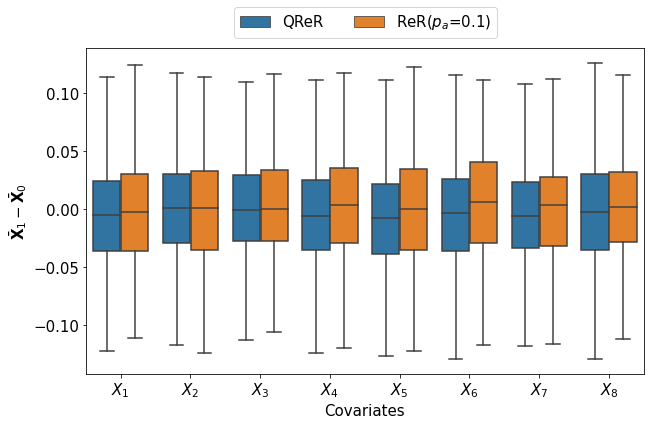

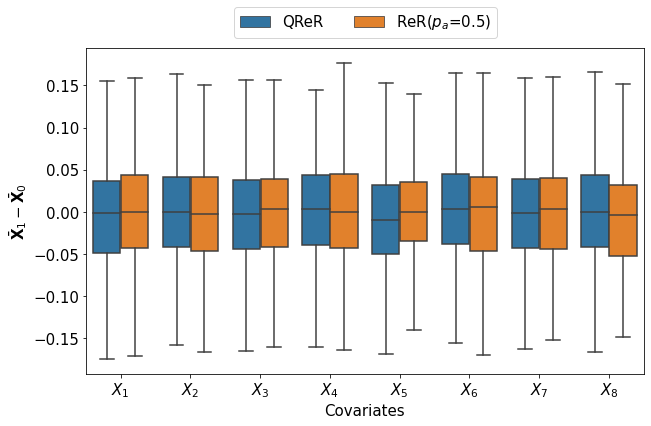

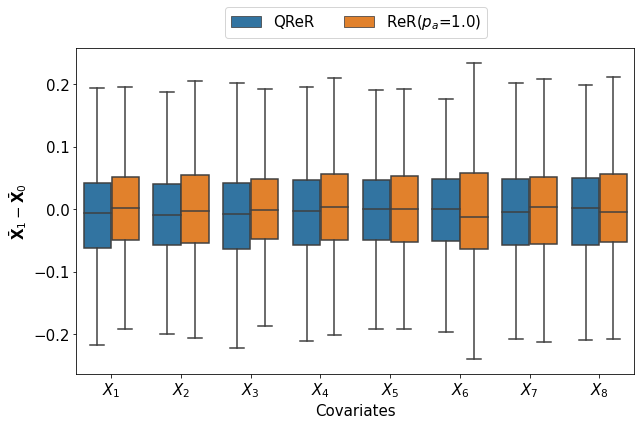

In [5]:
for pa in [0.1,0.5,1]:
    batch_size = 512
    lr = 1e-3#1e-3#5e-4
    init_method = 'normal'
    val_metric = 'KS'#'KS'#'Loss'
    x_lambda = 1
    wt_lambda = 1
    num_nodes = 512
    num_iters = 5000
    num_noval_iters = 0#1000
    num_init_iters = 500
    patience = 15
    save_folder = './save/'
    random_state = 0
    kernel_params = {'kernel':'rbf',
                     'gamma':10, 
                     'degree':2,
                     'c':1}

    save_folder_qrer = save_folder_root + 'qrer/pa='+str(pa)+'/'
    if not os.path.exists(save_folder_qrer):
        print('Creat the folder for QReR.')
        os.makedirs(save_folder_qrer)

    if not os.path.exists(save_folder_qrer +'final_checkpoint.pt'):
        print('Train the model from scratch.')

        estimator = QRWG(lr=lr,
                         batch_size=batch_size,
                         patience=patience,
                         num_iters=num_iters,
                         num_init_iters=num_init_iters,
                         num_noval_iters=num_noval_iters,
                         pa=pa,
                         x_lambda=x_lambda,
                         wt_lambda=wt_lambda,
                         num_nodes=num_nodes,
                         save_folder=save_folder_qrer,
                         val_metric=val_metric,
                         verbose=True,
                         kernel_params=kernel_params,
                         random_state=random_state)
    
        estimator.fit(x,z)
    else:
        print('Skip! The model has been trained.')
        estimator = QRWG(lr=lr,
                          batch_size=batch_size,
                          patience=patience,
                          num_iters=num_iters,
                          num_init_iters=1,
                          pa=pa,
                         x_lambda=x_lambda,
                         wt_lambda=wt_lambda,
                          num_nodes=num_nodes,
                          val_metric=val_metric,
                          save_folder=save_folder_qrer,
                          kernel_params=kernel_params,
                          verbose=False,
                          random_state=random_state)
        estimator.w = z
        estimator.nwts = int(estimator.w.shape[0])
        estimator.nt = int(z.sum())
        estimator.nc = int((1-z).sum())
        estimator._init_network()
        estimator.netG.load_state_dict(torch.load(save_folder_qrer+'final_checkpoint.pt'))
        
    # inference

    np.random.seed(seed)
    torch.manual_seed(seed)

    if not os.path.exists(save_folder+'mdist_pa'+str(pa*10)+'.npy'):

        # rerandomization
        z_mat_rer = np.array([ReR(pa,torch.Tensor(x),nt)[0].numpy() for i in range(1000)])
        np.save(save_folder+'zmat_pa'+str(pa*10)+'.npy',
            z_mat_rer)
        
        mdist_array = np.array([ReR(pa,torch.Tensor(x),np.sum(z))[1].item() for i in tqdm(range(1000))])
        np.save(save_folder+'mdist_pa'+str(pa*10)+'.npy',
            mdist_array)
    else:
        mdist_array = np.load(save_folder+'mdist_pa'+str(pa*10)+'.npy')
        z_mat_rer = np.load(save_folder+'zmat_pa'+str(pa*10)+'.npy')

    wts_mat_net = estimator.predict(1000).numpy()
    
    from scipy.stats import ks_2samp
    mdiff_mat_net = np.array([cov_mdiff(x,z,wts_mat_net[i]) for i in range(wts_mat_net.shape[0])])
    mdiff_mat_rer = np.array([cov_mdiff(x,z_mat_rer[i]) for i in range(z_mat_rer.shape[0])])
    ks_stats = np.mean(np.array([ks_2samp(mdiff_mat_net[:,i],mdiff_mat_rer[:,i]) for i in range(mdiff_mat_net.shape[1])]),axis=0)
    print('KS Statistics:',ks_stats)
    
    import pandas as pd

    df_mdiff_net = pd.DataFrame(mdiff_mat_net,columns=['$X_{'+str(i+1)+'}$' for i in range(mdiff_mat_net.shape[1])])
    df_mdiff_net['Method'] = 'QReR'
    df_mdiff_rer = pd.DataFrame(mdiff_mat_rer,columns=['$X_{'+str(i+1)+'}$' for i in range(mdiff_mat_rer.shape[1])])
    df_mdiff_rer['Method'] = 'ReR($p_a$=%.1f)'%(pa)

    df_mdiff = pd.concat([df_mdiff_net,df_mdiff_rer],axis=0)
    df_mdiff = pd.melt(df_mdiff,id_vars=['Method'],var_name=['Variable'],value_name='Value')
    
    plt.figure(figsize=(10,6))
    sb.boxplot(x='Variable',y='Value',
               hue="Method",data=df_mdiff,showfliers = False)
    plt.ylabel('$\\bar{\mathbf{X}}_1-\\bar{\mathbf{X}}_0$',fontsize=15)
    plt.xlabel('Covariates',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(bbox_to_anchor=(0.75, 1.15),ncol=2,fontsize=15)
    plt.savefig(save_folder_root+'/mdiff_pa'+str(int(pa*10))+'.pdf')